# Summary

<p class='lead'>
This notebook computes the auto and cross-correlation between spots and pixels
from a smFRET experiment on a 48-spot smFRET-PAX setup.
</p>

# Find data file

In [1]:
fname = 'data/pax-2017-07-11_06_12d_22d_mix_D200mW_A400mW.hdf5'

In [2]:
from pathlib import Path
fname = Path(fname)
assert fname.is_file(), 'File not found.'
mlabel = '_'.join(fname.stem.replace('pax-', '').replace('alex-', '').split('_')[:3])
mlabel

'2017-07-11_06_12d'

In [3]:
import time
time.ctime()

'Tue Oct 31 11:23:26 2017'

# Imports

In [4]:
import os
import numpy as np
from IPython.display import display, HTML, Math
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from tqdm import tnrange, tqdm_notebook

%matplotlib inline
plt.rcParams['font.sans-serif'].insert(0, 'Arial')
plt.rcParams['font.size'] = 14
plt.rcParams['path.simplify'] = True
plt.rcParams['path.simplify_threshold'] = 1

In [5]:
import pycorrelate as pyc
pyc.__version__

'0.1.0'

In [6]:
from fretbursts import *

 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.
--------------------------------------------------------------
 You are running FRETBursts (version 0.6.5).

 If you use this software please cite the following paper:

   FRETBursts: An Open Source Toolkit for Analysis of Freely-Diffusing Single-Molecule FRET
   Ingargiola et al. (2016). http://dx.doi.org/10.1371/journal.pone.0160716 

--------------------------------------------------------------


In [7]:
skip_ch = (12, 13)

In [8]:
save_figures = True
savefigdir = 'figures'
highres = False

# Define functions

In [9]:
def info_html(d):
    """Display measurement info in the notebook"""
    Dex, Aex = d.setup['excitation_input_powers']*1e3
    s = """
    <h3>File: &nbsp; &nbsp; &nbsp; {fname}</h3>
    <blockquote><p class="lead">{descr}</p></blockquote>
    <ul>
    <li><span style='display: inline-block; width: 150px;'>Acquisition duration:</span> {time:.1f} s </li>
    <li><span style='display: inline-block; width: 150px;'>Laser power:</span>  <b>{Dex:.0f}mW</b> @ 532nm &nbsp;&nbsp;&nbsp;  
                                                                                <b>{Aex:.0f}mW</b> @ 628nm </li>
    <li><span style='display: inline-block; width: 150px;'>ALEX period [offset]: </span> {period} ({period_us:.1f} μs)  [{offset}] </li></ul>
    """.format(fname=d.fname, time=float(d.acquisition_duration), Dex=Dex, Aex=Aex, 
               period=d.alex_period, period_us=d.alex_period*d.clk_p*1e6, offset=d.offset,
               descr=d.description.decode())
    return HTML(s)


def save_name(name, folder='.', label=None, nospaces=False):
    """Compute file name for saving a figure"""
    if label is None:
        label = mlabel
    sname = '%s/%s_%s' % (folder, label, name)
    if nospaces:
        sname = sname.replace(' ', '_')
    return sname 
    
def savefig(name, nospaces=True, label=None, **kwargs):
    """Save a figure prepending the measurement label and other options"""
    if not save_figures:
        return
    savefigpath = Path(savefigdir)
    savefigpath.mkdir(exist_ok=True)
    kwargs_ = dict(dpi=200, bbox_inches='tight')
                   #frameon=True, facecolor='white', transparent=False)
    kwargs_.update(kwargs)
    fname = save_name(name, savefigdir, nospaces=nospaces, label=label)
    plt.savefig(fname, **kwargs_)
    print('Saved: %s.png' % fname, flush=True)
    if highres:
        kwargs_['dpi'] = 300
        name = name[:-4] if name.lower().endswith('.png') else name
        fname = save_name(name + '_highres', savefigdir, nospaces=nospaces, label=label)
        print('Saved hires: %s.png' % fname, flush=True)
        plt.savefig(fname, **kwargs_)

In [10]:
def normalize_G(G, t, u, bins):
    """Normalize ACF and CCF.
    """
    duration = max((t.max(), u.max())) - min((t.min(), u.min()))
    Gn = G.copy()
    for i, tau in enumerate(bins[1:]):
        Gn[i] *= ((duration - tau) 
                  / (float((t >= tau).sum()) * 
                     float((u <= (u.max() - tau)).sum())))
    return Gn

# Load Data

In [11]:
d = loader.photon_hdf5(str(fname), ondisk=True)

In [12]:
info_html(d)

## SPAD positions

We can get the SPAD positon information from the `/setup/detectors` group in Photon-HDF5.
We access this group in the loaded file like this:

In [13]:
detectors = d.setup['detectors']
print('Arrays in `detectors` dict:')
print([*detectors])

Arrays in `detectors` dict:
['counts', 'id', 'id_hardware', 'position', 'spot']


All the arrays in `/setup/detectors` have the same length, and is is equal to the number of detectors.
In this case all the arrays have length 96.

The **`spot`** array indicate the spot each detectors belongs to:

In [14]:
detectors['spot']

array([ 0,  0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,
        8,  9,  9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16,
       17, 17, 18, 18, 19, 19, 20, 20, 21, 21, 22, 22, 23, 23, 24, 24, 25,
       25, 26, 26, 27, 27, 28, 28, 29, 29, 30, 30, 31, 31, 32, 32, 33, 33,
       34, 34, 35, 35, 36, 36, 37, 37, 38, 38, 39, 39, 40, 40, 41, 41, 42,
       42, 43, 43, 44, 44, 45, 45, 46, 46, 47, 47], dtype=uint8)

The **`id`** array indicates the value used in `/photon_dataN/detectors` to indicate each detector:

In [15]:
detectors['id']

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1], dtype=uint8)

The **`id_hardware`** array indicates the original detctor number from the acquisition hardware:

In [16]:
detectors['id_hardware']

array([84,  0, 85,  1, 86,  2, 87,  3, 88,  4, 89,  5, 90,  6, 91,  7, 92,
        8, 93,  9, 94, 10, 95, 11, 72, 12, 73, 13, 74, 14, 75, 15, 76, 16,
       77, 17, 78, 18, 79, 19, 80, 20, 81, 21, 82, 22, 83, 23, 60, 24, 61,
       25, 62, 26, 63, 27, 64, 28, 65, 29, 66, 30, 67, 31, 68, 32, 69, 33,
       70, 34, 71, 35, 48, 36, 49, 37, 50, 38, 51, 39, 52, 40, 53, 41, 54,
       42, 55, 43, 56, 44, 57, 45, 58, 46, 59, 47], dtype=uint8)

The **`position`** array indicates the detector position on the chip, 
as a pair of (x, y) coordinates. For example `(0,0)` and `(11, 3)`
are positions of diagonally opposite corners on the SPAD array.

In [17]:
detectors['position'][:5]

array([[11,  3],
       [11,  3],
       [10,  3],
       [10,  3],
       [ 9,  3]], dtype=uint8)

In [18]:
def pixel_rowcol_to_ch(d, row, col):
    i = np.where((d.setup['detectors']['position'] == (row, col)).sum(axis=1) == 2)[0][0]
    ich = d.setup['detectors']['spot'][i]
    return ich

# Spotwise

## Cross-correlation between spots

We compute the CCF betweel all-photons in two nearby spots.
We choose all the closest pairs in the 2x2 central pixels.
These pixels have the largest signal so if something is detectable it should
show up for these pairs.

In [19]:
pos_pairs = [
    ([5, 2], [6, 2]),
    ([5, 1], [6, 1]),
    ([5, 1], [5, 2]),
    ([6, 1], [6, 2]),
]

In [20]:
unit = d.clk_p
bins = pyc.make_loglags(-3, 1, 10) / unit

In [21]:
bins.astype('int')

array([    80000,    100714,    126791,    159620,    200950,    252982,
          318485,    400949,    504765,    635462,    800000,   1007140,
         1267914,   1596209,   2009509,   2529822,   3184857,   4009497,
         5047658,   6354625,   8000000,  10071403,  12679145,  15962098,
        20095091,  25298221,  31848573,  40094978,  50476587,  63546258,
        80000000, 100714032, 126791455, 159620985, 200950914, 252982212,
       318485736, 400949786, 504765875, 635462587, 800000000])

In [22]:
GG = []
GN = []
for pos1, pos2 in tqdm_notebook(pos_pairs):
    print('Processing positions %s, %s' % (pos1, pos2), flush=True)
    ich1 = pixel_rowcol_to_ch(d, *pos1)
    ich2 = pixel_rowcol_to_ch(d, *pos2)
    t = d.ph_times_t[ich1][:]
    u = d.ph_times_t[ich2][:]
    G = pyc.pcorrelate(t, u, bins)
    GG.append(G)
    GN.append(normalize_G(G, t, u, bins))

A Jupyter Widget

Processing positions [5, 2], [6, 2]
Processing positions [5, 1], [6, 1]
Processing positions [5, 1], [5, 2]
Processing positions [6, 1], [6, 2]



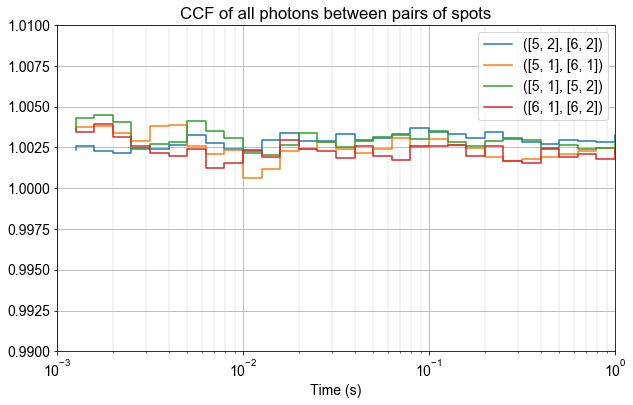

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))
for G, pair in zip(GN, pos_pairs):
    plt.semilogx(bins[1:]*unit, G, drawstyle='steps-pre', label=pair)
plt.xlabel('Time (s)')
plt.grid(True); plt.grid(True, which='minor', lw=0.3)
plt.legend()
plt.title('CCF of all photons between pairs of spots')
plt.xlim(1e-3, 1);
plt.ylim(0.99, 1.01);

> **NOTE** The effect of molecule diffusing from a spot to the other should
> be visible as a correlation between 10^-2 and 10^-1 s. In the above plot
> there may be something
> if we look it with loving eyes, but nothing we can rely on. Trying to extract any
> probability from such data would be pointless.

## Auto-correlation for spots

In [24]:
unit = d.clk_p
bins_per_dec = 10
bins = pyc.make_loglags(-8, 1, bins_per_dec) / unit

In [25]:
acf_fname =   f'results/{mlabel}_ACF_all-ph_spots_bins{bins_per_dec}.csv'
acf_fname_n = f'results/{mlabel}_ACF_all-ph_spots_bins{bins_per_dec}_normalized.csv'
acf_fname

'results/2017-07-11_06_12d_ACF_all-ph_spots_bins10.csv'

In [26]:
recompute = False
if Path(acf_fname_n).exists() and not recompute:
    print('- Loading ACF from cache', flush=True)
    GG = np.loadtxt(acf_fname)
    GN = np.loadtxt(acf_fname_n)
else:
    GG = np.zeros((48, bins.size - 1), dtype=float)
    GN = GG.copy()
    for ich in tnrange(48, desc='Calculating ACFs: '):
        if ich in skip_ch:
            continue
        #print('Processing spot %s ...' % ich, flush=True)
        t = d.ph_times_t[ich][:]
        G = pyc.pcorrelate(t, t, bins)
        Gn = normalize_G(G, t, t, bins)
        GG[ich] += G
        GN[ich] += Gn
    np.savetxt(acf_fname, GG)
    np.savetxt(acf_fname_n, GN)

- Loading ACF from cache


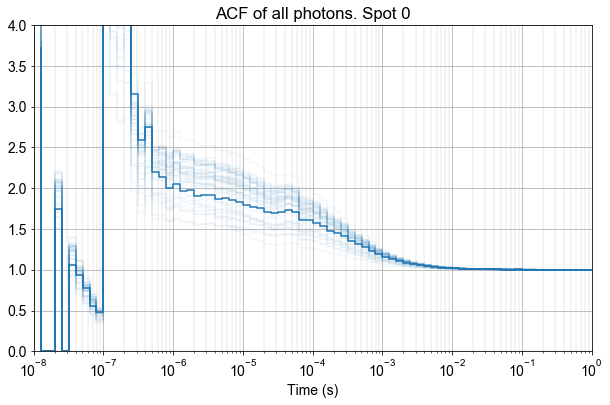

In [27]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.xlabel('Time (s)')
plt.grid(True); plt.grid(True, which='minor', lw=0.3)
plt.title('ACF of all photons. Spot %d' % 0)
plt.ylim(0.0, 4)
plt.xlim(10**-8, 1)
lines = plt.semilogx(bins[1:]*unit, GN.T, drawstyle='steps-pre', alpha=0.05, color='C0')
line = lines[0]
line.set_alpha(1)

In [28]:
@interact(
    spot=(0, 47), 
    ylim=widgets.FloatRangeSlider(value=[0, 7.5], min=0, max=10.0, step=0.1,))
def plot_spot(spot, ylim):
    for line in lines:
        line.set_alpha(0.05)
    line = lines[spot]
    line.set_alpha(1)
    ax.set_ylim(ylim)
    ax.set_title('ACF of all photons. Spot %d' % spot)
    display(fig)

A Jupyter Widget

# Pixelwise

## Cross-correlations between pixels

In [29]:
pos_pairs = [
    ([4, 1], [4, 2]),
    ([4, 2], [5, 2]),
    ([4, 1], [5, 1]),
    ([5, 1], [5, 2]),
    #([5, 2], [6, 2]),
    #([5, 1], [6, 1]),
    #([6, 1], [6, 2]),
]

In [30]:
p = np.array(pos_pairs).reshape(len(pos_pairs)*2, 2)
spots = np.unique([pixel_rowcol_to_ch(d, *i) for i in p])
str(spots)

'[18 19 30 31]'

In [31]:
unit = d.clk_p
bins_per_dec = 10
bins = pyc.make_loglags(-8, 1, bins_per_dec) / unit

In [32]:
ccf_fname =   f'results/{mlabel}_CCF_pixels_{str(spots)}_bins{bins_per_dec}.csv'
ccf_fname_n = f'results/{mlabel}_CCF_pixels_{str(spots)}_bins{bins_per_dec}_normalized.csv'
ccf_fname

'results/2017-07-11_06_12d_CCF_pixels_[18 19 30 31]_bins10.csv'

In [33]:
recompute = False
if Path(ccf_fname_n).exists() and not recompute:
    print('- Loading CCF from cache', flush=True)
    XC = np.loadtxt(ccf_fname).reshape(2, len(spots), -1)
    XCN = np.loadtxt(ccf_fname_n).reshape(2, len(spots), -1)
else:
    XC = np.zeros((2, len(pos_pairs), bins.size - 1), dtype=float)
    XCN = np.zeros((2, len(pos_pairs), bins.size - 1), dtype=float)
    for ipair, (pos1, pos2) in tqdm_notebook(enumerate(pos_pairs), total=len(pos_pairs), desc='Spot pair'):
        print('Processing positions %s, %s' % (pos1, pos2), flush=True)
        ich1 = pixel_rowcol_to_ch(d, *pos1)
        ich2 = pixel_rowcol_to_ch(d, *pos2)

        for donor_or_accept in tnrange(2, desc='Detector', leave=False):

            ph1 = d.ph_times_t[ich1][:]
            det = d.det_t[ich1][:]
            t = ph1[det == donor_or_accept]

            ph2 = d.ph_times_t[ich2][:]
            det = d.det_t[ich2][:]
            u = ph2[det == donor_or_accept]

            G = pyc.pcorrelate(t, u, bins)

            XC[donor_or_accept, ipair] = G
            XCN[donor_or_accept, ipair] = normalize_G(G, t, u, bins)
    np.savetxt(ccf_fname, XC.reshape(2*len(spots), -1))
    np.savetxt(ccf_fname_n, XCN.reshape(2*len(spots), -1))

- Loading CCF from cache


### CCFs plots

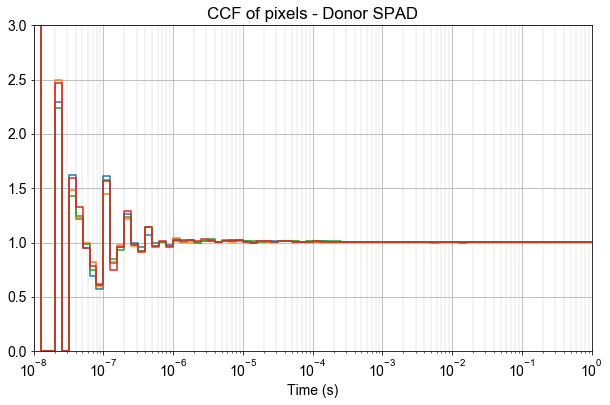

In [34]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.xlabel('Time (s)')
plt.grid(True); plt.grid(True, which='minor', lw=0.3)
plt.title('CCF of pixels - Donor SPAD')
plt.ylim(0, 3)
plt.xlim(10**-8, 1)
plt.semilogx(bins[1:]*unit, XCN[0].T, drawstyle='steps-pre');

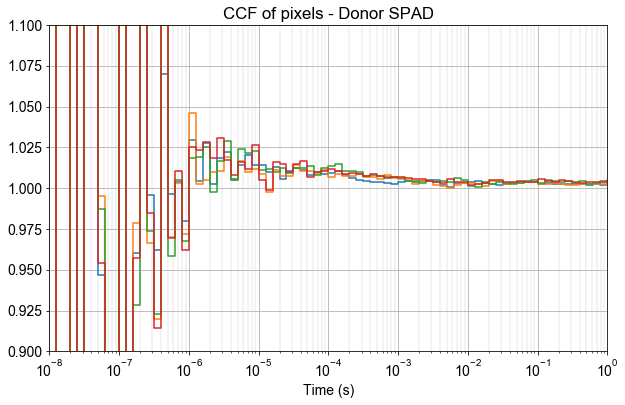

In [35]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.xlabel('Time (s)')
plt.grid(True); plt.grid(True, which='minor', lw=0.3)
plt.title('CCF of pixels - Donor SPAD')
plt.ylim(0.9, 1.1)
plt.xlim(10**-8, 1)
plt.semilogx(bins[1:]*unit, XCN[0].T, drawstyle='steps-pre');

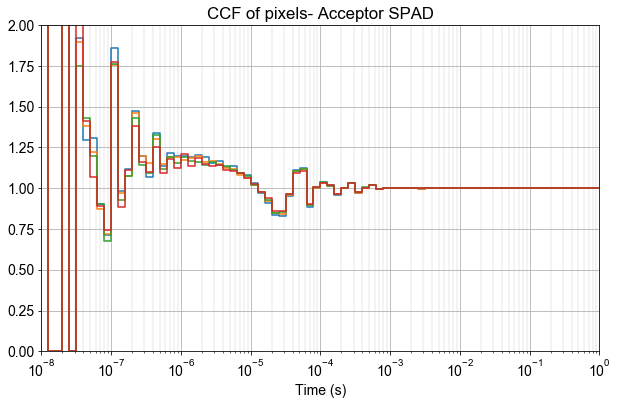

In [36]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.xlabel('Time (s)')
plt.grid(True); plt.grid(True, which='minor', lw=0.3)
plt.title('CCF of pixels- Acceptor SPAD')
plt.ylim(0, 2)
plt.xlim(10**-8, 1)
plt.semilogx(bins[1:]*unit, XCN[1].T, drawstyle='steps-pre');

## Auto-correlation for pixels

In [37]:
unit = d.clk_p
bins_per_dec = 10
bins = pyc.make_loglags(-8, 1, bins_per_dec) / unit

In [38]:
acf_fname = f'results/{mlabel}_ACF_all-ph_pixels_bins{bins_per_dec}.csv'
acf_fname_n = f'results/{mlabel}_ACF_all-ph_pixels_bins{bins_per_dec}_normalized.csv'
acf_fname

'results/2017-07-11_06_12d_ACF_all-ph_pixels_bins10.csv'

In [39]:
recompute = False
if Path(acf_fname_n).exists() and not recompute:
    print('- Loading ACF from cache', flush=True)
    GG = np.loadtxt(acf_fname).reshape(2, 48, -1)
    GN = np.loadtxt(acf_fname_n).reshape(2, 48, -1)
else:
    GG = np.zeros((2, 48, bins.size - 1), dtype=float)
    GN = GG.copy()
    for ich in tnrange(48, desc='Calculating ACFs: '):
        if ich in skip_ch:
            continue
        for donor_or_accept in (0, 1):
            ph = d.ph_times_t[ich][:]
            det = d.det_t[ich][:]
            t = ph[det == donor_or_accept]
            
            G = pyc.pcorrelate(t, t, bins)
            
            GG[donor_or_accept, ich] = G
            GN[donor_or_accept, ich] = normalize_G(G, t, t, bins)
    np.savetxt(acf_fname, GG.reshape(96, -1))
    np.savetxt(acf_fname_n, GN.reshape(96, -1))

- Loading ACF from cache


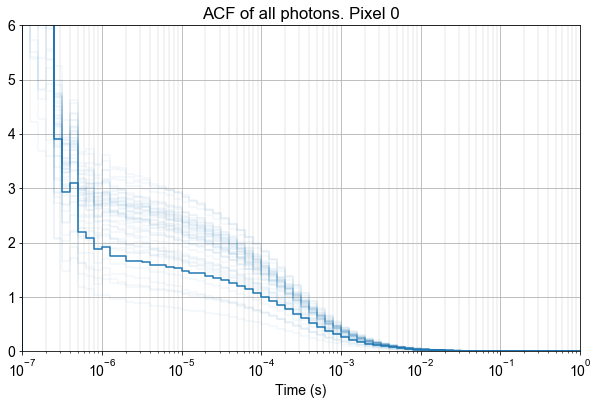

In [40]:
det = 0
fig, ax = plt.subplots(figsize=(10, 6))
def _plot(det):
    ax.set_xlabel('Time (s)')
    ax.grid(True); ax.grid(True, which='minor', lw=0.3)
    ax.set_title('ACF of all photons. Pixel %d' % 0)
    ax.set_ylim(0.0, 6)
    ax.set_xlim(10**-7, 1)
    return ax.semilogx(bins[1:]*unit, GN[det].T - 1, drawstyle='steps-pre', alpha=0.05, color='C0')
lines = _plot(det)
lines[0].set_alpha(1)

In [41]:
@interact(
     pixel=(0, 47),
     detector=['donor', 'acceptor'],
     ylim=widgets.FloatRangeSlider(value=[0, 7.5], min=0, max=10.0, step=0.1,))
def plot_spot(pixel, detector, ylim):
    global det, lines
    new_det = 0 if detector == 'donor' else 1
    if new_det != det:
        det = new_det
        ax.clear()
        lines = _plot(det)
    for line in lines:
        line.set_alpha(0.05)
    line = lines[pixel]
    line.set_alpha(1)
    ax.set_ylim(ylim)
    ax.set_title('ACF of all photons. Spot %d' % pixel)
    display(fig)

A Jupyter Widget

## Pixelwise ACF - CCF comparison

In [42]:
p = np.array(pos_pairs).reshape(len(pos_pairs)*2, 2)
spots = np.unique([pixel_rowcol_to_ch(d, *i) for i in p])
spots

array([18, 19, 30, 31], dtype=uint8)

In [43]:
np.reshape([pixel_rowcol_to_ch(d, *i) for i in p], (-1, 2))

array([[31, 19],
       [19, 18],
       [31, 30],
       [30, 18]], dtype=uint8)

Saved: figures/2017-07-11_06_12d_ACF-CCF_comparison.png


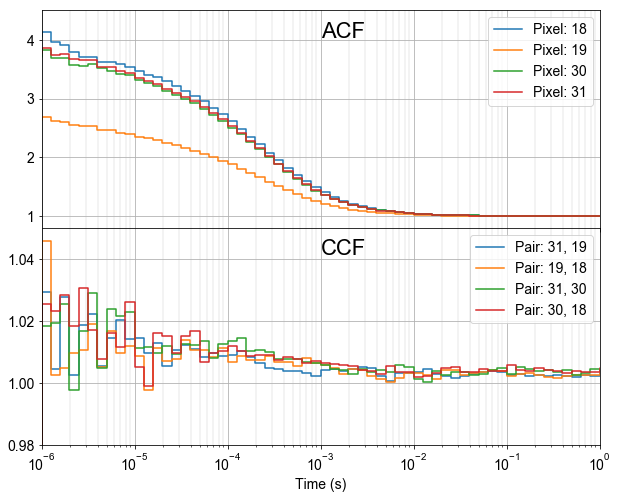

In [44]:
det = 0
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
plt.subplots_adjust(hspace=0)
for a in (ax, ax2):
    a.grid(True)
    a.grid(True, which='minor', lw=0.3)
#ax.set_title('ACF of all photons. Donor SPAD')
ax.set_ylim(0.8, 4.5)
ax.set_xlim(10**-6, 1)
for spot in spots:
    ax.semilogx(bins[1:]*unit, GN[det][spot], drawstyle='steps-pre', 
                label='Pixel: %d' % spot)
ax.legend()
#ax2 = plt.twinx()
ax2.semilogx(bins[1:]*unit, XCN[det].T, drawstyle='steps-pre');
ax2.legend([f'Pair: {i}, {j}' for i, j in np.reshape([pixel_rowcol_to_ch(d, *i) for i in p], (-1, 2))])
ax2.set_ylim(0.98, 1.05)

ax.text(0.5, 0.95, 'ACF', transform=ax.transAxes, va='top', fontsize=22)
ax2.text(0.5, 0.95, 'CCF', transform=ax2.transAxes, va='top', fontsize=22)
ax2.set_xlabel('Time (s)');
savefig('ACF-CCF comparison')

# Burst-filtered

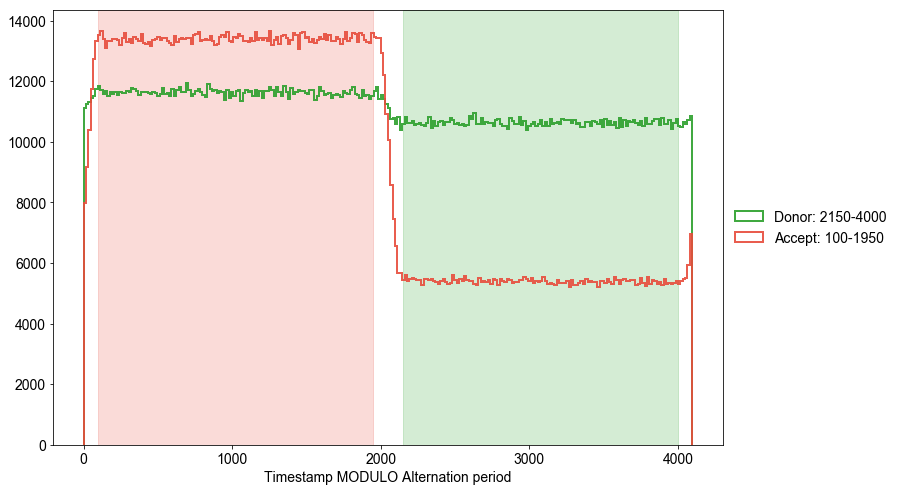

In [45]:
fig, ax = plt.subplots(figsize=(12, 8))
bpl.plot_alternation_hist_usalex(d, ax=ax, bins=np.arange(0, 4097, 16))

In [46]:
loader.alex_apply_period(d)

# Total photons (after ALEX selection):   287,744,125
#  D  photons in D+A excitation periods:  142,294,620
#  A  photons in D+A excitation periods:  145,449,505
# D+A photons in  D  excitation period:   110,565,293
# D+A photons in  A  excitation period:   177,178,832



In [47]:
d.calc_bg_cache(bg.exp_fit, time_s=5, tail_min_us='auto', F_bg=1.7)

 * Loading BG rates from cache ... 
 - Loading bakground data:  [DONE]


In [48]:
d.burst_search(min_rate_cps=50e3, pax=True)

 - Performing burst search (verbose=False) ...[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   [DONE Counting D/A]


In [49]:
d.ph_in_bursts_ich()

array([   13972262,    13972785,    13976637, ..., 49504596221,
       49504597600, 49504598610], dtype=int64)

## ACF for pixels bursts

In [50]:
unit = d.clk_p
bins_per_dec = 10
bins = pyc.make_loglags(-8, 1, bins_per_dec) / unit

In [51]:
acf_fname = f'results/{mlabel}_ACF_all-ph_pixels-bursts-all-ph_bins{bins_per_dec}.csv'
acf_fname_n = f'results/{mlabel}_ACF_all-ph_pixels-bursts-all-ph_bins{bins_per_dec}_normalized.csv'
acf_fname

'results/2017-07-11_06_12d_ACF_all-ph_pixels-bursts-all-ph_bins10.csv'

In [52]:
recompute = False
if Path(acf_fname_n).exists() and not recompute:
    print('- Loading ACF from cache', flush=True)
    GG = np.loadtxt(acf_fname)
    GN = np.loadtxt(acf_fname_n)
else:
    GG = np.zeros((48, bins.size - 1), dtype=float)
    GN = GG.copy()
    for ich in tnrange(48, desc='Calculating ACFs: '):
        if ich in skip_ch:
            continue
        t = d.ph_in_bursts_ich(ich)
        G = pyc.pcorrelate(t, t, bins)
        GG[ich] = G
        GN[ich] = normalize_G(G, t, t, bins)     
    np.savetxt(acf_fname, GG)
    np.savetxt(acf_fname_n, GN)

- Loading ACF from cache


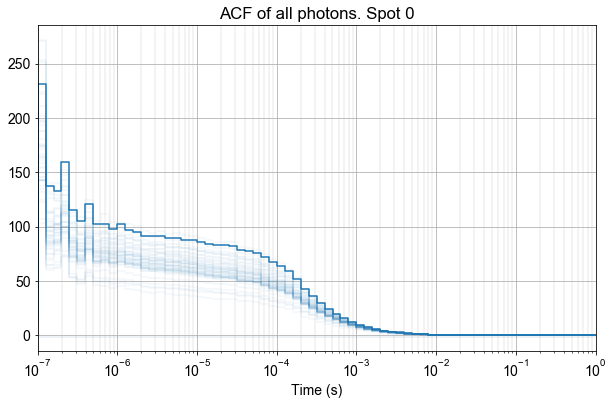

In [53]:
det = 0
fig, ax = plt.subplots(figsize=(10, 6))
def _plot(det):
    ax.set_xlabel('Time (s)')
    ax.grid(True); ax.grid(True, which='minor', lw=0.3)
    ax.set_title('ACF of all photons. Spot %d' % 0)
    #ax.set_ylim(0.0, 6)
    ax.set_xlim(10**-7, 1)
    return ax.semilogx(bins[1:]*unit, GN.T - 1, drawstyle='steps-pre', alpha=0.05, color='C0')
lines = _plot(det)
lines[0].set_alpha(1)

In [54]:
@interact(
     pixel=(0, 47),
     ylim=widgets.FloatRangeSlider(value=[0, 150], min=0, max=200, step=1,))
def plot_spot(pixel, ylim):
    for line in lines:
        line.set_alpha(0.05)
    line = lines[pixel]
    line.set_alpha(1)
    ax.set_ylim(ylim)
    ax.set_title('ACF of all photons. Spot %d' % pixel)
    display(fig)

A Jupyter Widget

## CCF for pixels bursts

In [55]:
pos_pairs = [
    ([5, 2], [6, 2]),
    ([5, 1], [6, 1]),
    ([5, 1], [5, 2]),
    ([6, 1], [6, 2]),
]

In [56]:
unit = d.clk_p
bins = pyc.make_loglags(-8, 1, 10) / unit

In [57]:
XC = np.zeros((2, len(pos_pairs), bins.size - 1), dtype=float)
XCN = np.zeros((2, len(pos_pairs), bins.size - 1), dtype=float)
for ipair, (pos1, pos2) in tqdm_notebook(enumerate(pos_pairs), total=len(pos_pairs), desc='Spot pair'):
    print('Processing positions %s, %s' % (pos1, pos2), flush=True)
    ich1 = pixel_rowcol_to_ch(d, *pos1)
    ich2 = pixel_rowcol_to_ch(d, *pos2)
    
    for i_det, ph_sel in enumerate((Ph_sel(Dex='Dem', Aex='Dem'), Ph_sel(Dex='Aem', Aex='Aem'))):
        t = d.ph_in_bursts_ich(ich1, ph_sel=ph_sel)
        u = d.ph_in_bursts_ich(ich2, ph_sel=ph_sel)
        
        G = pyc.pcorrelate(t, u, bins)
        
        XC[i_det, ipair] = G
        XCN[i_det, ipair] = normalize_G(G, t, u, bins)

A Jupyter Widget

Processing positions [5, 2], [6, 2]
Processing positions [5, 1], [6, 1]
Processing positions [5, 1], [5, 2]
Processing positions [6, 1], [6, 2]



### CCFs plots

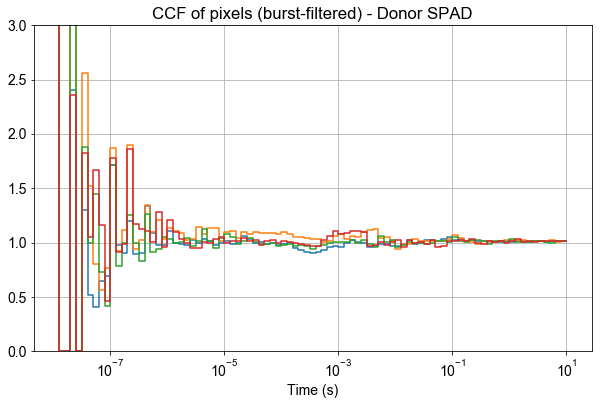

In [58]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.xlabel('Time (s)')
plt.grid(True); plt.grid(True, which='minor', lw=0.3)
plt.title('CCF of pixels (burst-filtered) - Donor SPAD')
plt.ylim(0, 3)
#plt.xlim(10**-8, 1)
plt.semilogx(bins[1:]*unit, XCN[0].T, drawstyle='steps-pre');

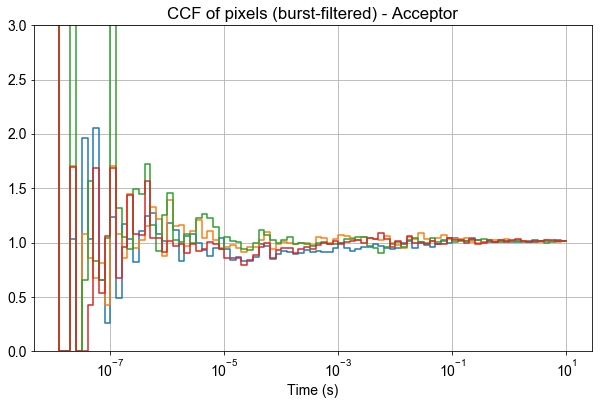

In [59]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.xlabel('Time (s)')
plt.grid(True); plt.grid(True, which='minor', lw=0.3)
plt.title('CCF of pixels (burst-filtered) - Acceptor')
plt.ylim(0, 3)
#plt.xlim(10**-8, 1)
plt.semilogx(bins[1:]*unit, XCN[1].T, drawstyle='steps-pre');